# test01
## More testing, but with brownian motion

In [31]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_curve, auc
from prophet_rmse import stock_rmse
import seaborn as sns
from datetime import datetime, timezone

[*********************100%***********************]  1 of 1 completed


array([[48.88016046, 48.75607736, 48.79989497, ..., 48.85442133,
        48.80249023, 48.720651  ],
       [48.86566783, 48.75977732, 48.85306901, ..., 48.85666516,
        48.78564685, 48.71395358],
       [48.86805888, 48.78846323, 48.83881095, ..., 48.84283898,
        48.77965385, 48.76786374],
       ...,
       [48.42295739, 49.23270863, 47.98717684, ..., 47.60611013,
        47.76337766, 49.04837794],
       [48.43521925, 49.27156966, 48.01307625, ..., 47.62047139,
        47.77714139, 48.97661223],
       [48.45408889, 49.23487191, 47.96965795, ..., 47.59578475,
        47.83873249, 49.01194182]])

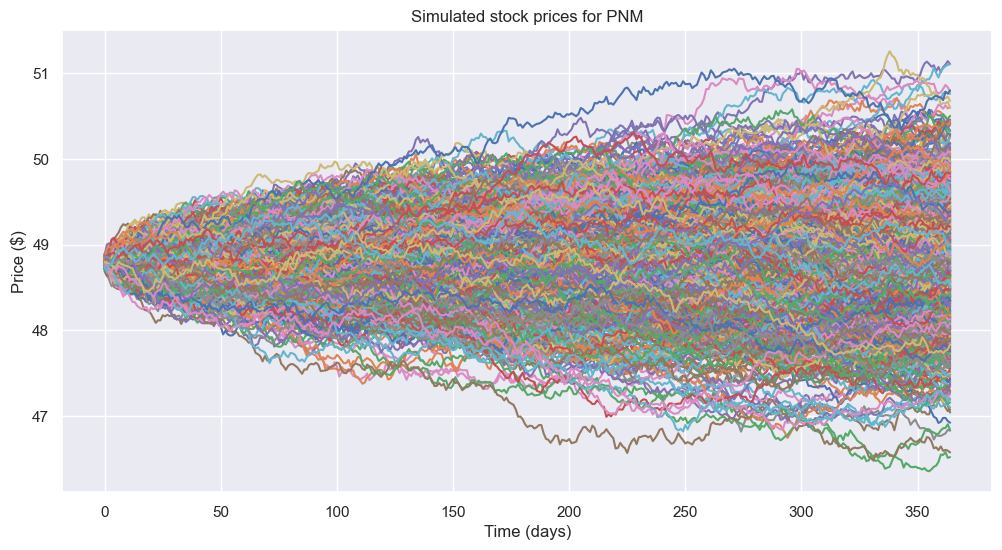

In [32]:
# Load stock data for a particular ticker
ticker = "PNM"
raw_data = yf.download(ticker, start="2010-01-01", end="2023-04-10", interval='1d')

# Compute daily returns and volatility
log_returns = np.log(1 + raw_data['Adj Close'].pct_change())
volatility = log_returns.std()

# Define parameters for Brownian motion
S0 = raw_data['Adj Close'][-1] # current stock price
T = 365 # number of days to simulate
N = 1000 # number of simulations
dt = 1/365 # time step
mu = log_returns.mean() # expected return

# Simulate Brownian motion
W = np.random.standard_normal(size=(T,N))
W = np.cumsum(W,axis=0)
X = (mu - 0.5 * volatility**2) * dt + volatility * np.sqrt(dt) * W
S = S0 * np.exp(X)

# Plot simulated stock prices
plt.figure(figsize=(12,6))
plt.plot(S)
plt.title(f'Simulated stock prices for {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.savefig('out.png')
S

In [33]:
# Prepare data for Prophet model
df = pd.DataFrame({'ds': raw_data.index, 'y': raw_data['Adj Close']})
df.reset_index(inplace=True, drop=True)
print('done')

done


**building, compiling, and training the model**

13:45:33 - cmdstanpy - INFO - Chain [1] start processing
13:45:39 - cmdstanpy - INFO - Chain [1] done processing


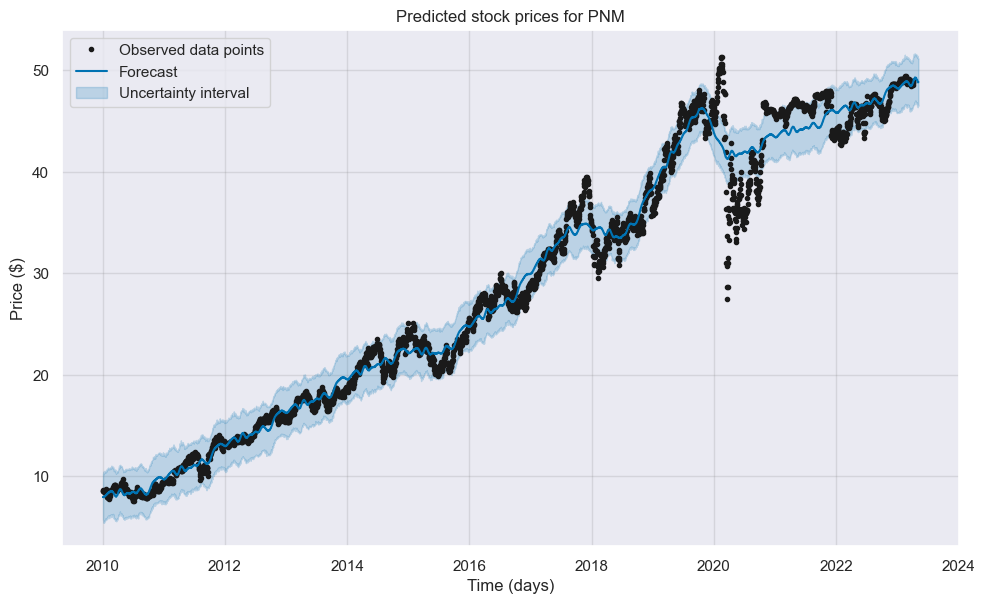

In [34]:
# Create and fit the Prophet model
m = Prophet(daily_seasonality=True)

m.fit(df)

# Generate predictions for the next 30 days
future = m.make_future_dataframe(periods=30)
forecast = m.predict(future)

# Plot the predicted prices
fig = m.plot(forecast)
plt.title(f'Predicted stock prices for {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

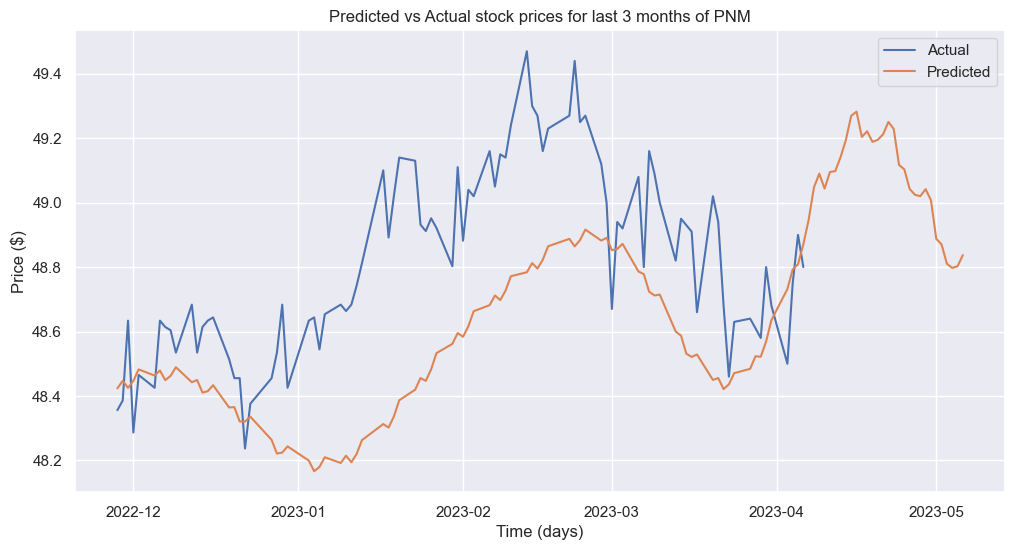

In [35]:
# Plot the predicted vs actual prices for range
last_month = forecast.iloc[-120:]
last_month_actual = raw_data.iloc[-90:]
fig2 = plt.figure(figsize=(12,6))
plt.plot(last_month_actual.index, last_month_actual['Adj Close'], label='Actual')
plt.plot(last_month.ds, last_month.yhat, label='Predicted')
plt.title(f'Predicted vs Actual stock prices for last 3 months of {ticker}')
plt.xlabel('Time (days)')
plt.ylabel('Price ($)')
plt.autoscale()
plt.legend()
plt.savefig('out1.png')
plt.show()

**model evaluation**

In [36]:
# Compute evaluation metrics
actual = raw_data['Adj Close'][-90:]
predicted = forecast['yhat'][-120:-30]
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)

# Print the evaluation metrics
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 0.30
MSE: 0.13
RMSE: 0.36


In [37]:
# Print the predicted stock prices for the next 30 days
print("Predicted and actual stock prices for the next 30 days:")
print(forecast[['ds', 'yhat']][-60:-30], raw_data['Adj Close'][-30:])

Predicted and actual stock prices for the next 30 days:
             ds       yhat
3308 2023-02-24  48.916477
3309 2023-02-27  48.882264
3310 2023-02-28  48.890998
3311 2023-03-01  48.852537
3312 2023-03-02  48.856112
3313 2023-03-03  48.872233
3314 2023-03-06  48.786295
3315 2023-03-07  48.778150
3316 2023-03-08  48.723541
3317 2023-03-09  48.712049
3318 2023-03-10  48.714545
3319 2023-03-13  48.599824
3320 2023-03-14  48.587170
3321 2023-03-15  48.531042
3322 2023-03-16  48.521225
3323 2023-03-17  48.528739
3324 2023-03-20  48.449702
3325 2023-03-21  48.455675
3326 2023-03-22  48.421291
3327 2023-03-23  48.436081
3328 2023-03-24  48.470743
3329 2023-03-27  48.484272
3330 2023-03-28  48.523180
3331 2023-03-29  48.521860
3332 2023-03-30  48.569262
3333 2023-03-31  48.635493
3334 2023-04-03  48.731721
3335 2023-04-04  48.792406
3336 2023-04-05  48.809185
3337 2023-04-06  48.870624 Date
2023-02-24    49.270000
2023-02-27    49.119999
2023-02-28    49.000000
2023-03-01    48.669998
2023-0

In [38]:
forecast[['ds', 'yhat']][-30:]

,ds,yhat
3338,2023-04-07,48.946521
3339,2023-04-08,49.047493
3340,2023-04-09,49.090048
3341,2023-04-10,49.043644
3342,2023-04-11,49.095080
3343,2023-04-12,49.097978
3344,2023-04-13,49.141126
3345,2023-04-14,49.194630
3346,2023-04-15,49.269500
3347,2023-04-16,49.282708


,ds,yhat
3323,2023-03-17,48.528739
3324,2023-03-20,48.449702
3325,2023-03-21,48.455675
3326,2023-03-22,48.421291
3327,2023-03-23,48.436081
3328,2023-03-24,48.470743
3329,2023-03-27,48.484272
3330,2023-03-28,48.523180
3331,2023-03-29,48.521860
3332,2023-03-30,48.569262


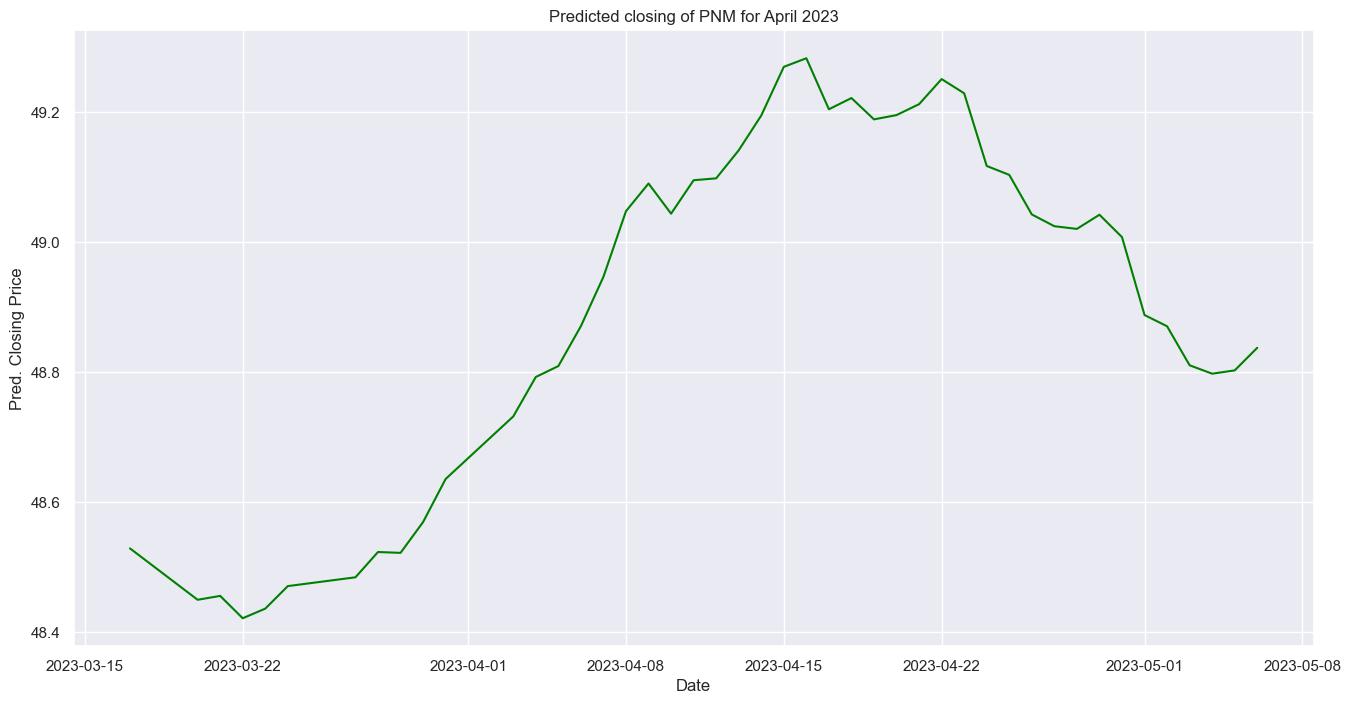

In [39]:
sns.lineplot(forecast[['ds', 'yhat']][-45:], x='ds', y='yhat', c='green')
sns.set(rc={"figure.figsize":(16, 8)}) #width=8, height=4
plt.xlabel('Date')
plt.ylabel('Pred. Closing Price')
plt.title(f'Predicted closing of {ticker} for April 2023')
forecast[['ds', 'yhat']][-45:]

In [40]:
stock_rmse('AAPL')

[*********************100%***********************]  1 of 1 completed


13:45:45 - cmdstanpy - INFO - Chain [1] start processing
13:45:48 - cmdstanpy - INFO - Chain [1] done processing


{'ticker': 'AAPL',
 'yhat': 0         6.135488
 1         6.057510
 2         6.043066
 3         5.930722
 4         5.839934
            ...    
 3329    168.486818
 3330    168.570842
 3331    168.569172
 3332    168.599720
 3333    168.888057
 Name: yhat, Length: 3334, dtype: float64,
 'yhat_lower': 0        -3.852321
 1        -3.626261
 2        -3.820971
 3        -3.650889
 4        -3.859618
            ...    
 3329    158.395464
 3330    158.573044
 3331    158.845368
 3332    158.559398
 3333    159.606160
 Name: yhat_lower, Length: 3334, dtype: float64,
 'yhat_upper': 0        16.382411
 1        15.678887
 2        16.142049
 3        15.416049
 4        16.289944
            ...    
 3329    178.671164
 3330    178.664156
 3331    178.637207
 3332    179.124722
 3333    178.893882
 Name: yhat_upper, Length: 3334, dtype: float64,
 'trend': 0         6.351002
 1         6.362145
 2         6.373288
 3         6.384431
 4         6.395575
            ...    
 3329    169.73